In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
from pandas.plotting import scatter_matrix

df = pd.read_csv('housing.csv')

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           20640 non-null  float64
 1   latitude            20640 non-null  float64
 2   housing_median_age  20640 non-null  float64
 3   total_rooms         20640 non-null  float64
 4   total_bedrooms      20433 non-null  float64
 5   population          20640 non-null  float64
 6   households          20640 non-null  float64
 7   median_income       20640 non-null  float64
 8   median_house_value  20640 non-null  float64
 9   ocean_proximity     20640 non-null  object 
dtypes: float64(9), object(1)
memory usage: 1.6+ MB


In [3]:
y = df.iloc[:,-2]
x = df.iloc[:,:-2]

x_train,x_test,y_train,y_test = train_test_split(x,y,test_size = 0.33)

In [4]:
train_set, test_set = train_test_split(df, test_size=0.2,random_state=42)

test_set.value_counts(df['median_income']) / len(test_set)

,count
median_income,
4.0000,0.004118
3.8750,0.002665
2.8750,0.002665
1.6250,0.002422
3.5000,0.002422
...,...
2.9640,0.000242
2.9663,0.000242
2.9712,0.000242


In [49]:
df['categories'] = pd.cut(df['median_income'],bins= [0.,1.5,3,4.5,6,np.inf], labels= [1,2,3,4,5])

In [6]:
strat_train_set, strat_test_set = train_test_split(df, test_size=0.2, stratify=df['categories'] ,random_state=42)

strat_test_set['categories'].value_counts() / len(strat_test_set)

,count
categories,
3,0.350533
2,0.318798
4,0.176357
5,0.114341
1,0.039971


In [24]:
df = strat_train_set.drop(["median_house_value",'categories'], axis=1) # drop labels for training set
df_labels = strat_train_set["median_house_value"].copy()

In [25]:
df.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,ocean_proximity
12655,-121.46,38.52,29.0,3873.0,797.0,2237.0,706.0,2.1736,INLAND
15502,-117.23,33.09,7.0,5320.0,855.0,2015.0,768.0,6.3373,NEAR OCEAN
2908,-119.04,35.37,44.0,1618.0,310.0,667.0,300.0,2.8750,INLAND
14053,-117.13,32.75,24.0,1877.0,519.0,898.0,483.0,2.2264,NEAR OCEAN
20496,-118.70,34.28,27.0,3536.0,646.0,1837.0,580.0,4.4964,<1H OCEAN


In [26]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder

In [27]:
df.isnull().sum()

,0
longitude,0
latitude,0
housing_median_age,0
total_rooms,0
total_bedrooms,158
population,0
households,0
median_income,0
ocean_proximity,0


In [28]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

df_num = df.drop('ocean_proximity', axis=1)

num_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('std_scaler', StandardScaler()),
])

df_num_tr = num_pipeline.fit_transform(df_num)

In [29]:
df_num_tr

array([[-0.94135046,  1.34743822,  0.02756357, ...,  0.73260236,
         0.55628602, -0.8936472 ],
       [ 1.17178212, -1.19243966, -1.72201763, ...,  0.53361152,
         0.72131799,  1.292168  ],
       [ 0.26758118, -0.1259716 ,  1.22045984, ..., -0.67467519,
        -0.52440722, -0.52543365],
       ...,
       [-1.5707942 ,  1.31001828,  1.53856552, ..., -0.86201341,
        -0.86511838, -0.36547546],
       [-1.56080303,  1.2492109 , -1.1653327 , ..., -0.18974707,
         0.01061579,  0.16826095],
       [-1.28105026,  2.02567448, -0.13148926, ..., -0.71232211,
        -0.79857323, -0.390569  ]])

In [57]:
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestRegressor

num_attribs = list(df_num)
cat_attribs = ['ocean_proximity']

full_preprocessing = ColumnTransformer([
    ('num', num_pipeline, num_attribs),
    ('cat', OneHotEncoder(handle_unknown="ignore"),cat_attribs),
])
df_prepared = full_preprocessing.fit_transform(df)

In [58]:
df_prepared

array([[-0.94135046,  1.34743822,  0.02756357, ...,  0.        ,
         0.        ,  0.        ],
       [ 1.17178212, -1.19243966, -1.72201763, ...,  0.        ,
         0.        ,  1.        ],
       [ 0.26758118, -0.1259716 ,  1.22045984, ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [-1.5707942 ,  1.31001828,  1.53856552, ...,  0.        ,
         0.        ,  0.        ],
       [-1.56080303,  1.2492109 , -1.1653327 , ...,  0.        ,
         0.        ,  0.        ],
       [-1.28105026,  2.02567448, -0.13148926, ...,  0.        ,
         0.        ,  0.        ]])

In [32]:
## TO Get the best params and important features

from sklearn.model_selection import GridSearchCV
param_grid = [

    {'n_estimators': [3, 10, 30], 'max_features': [2, 4, 6, 8]},
    {'bootstrap': [False], 'n_estimators': [3, 10], 'max_features': [2, 3, 4]},
  ]

forest_reg = RandomForestRegressor(random_state=42)

grid_search = GridSearchCV(forest_reg, param_grid, cv=5,
                           scoring='neg_mean_squared_error',
                           return_train_score=True)
grid_search.fit(df_prepared, df_labels)

GridSearchCV(cv=5, estimator=RandomForestRegressor(random_state=42),
             param_grid=[{'max_features': [2, 4, 6, 8],
                          'n_estimators': [3, 10, 30]},
                         {'bootstrap': [False], 'max_features': [2, 3, 4],
                          'n_estimators': [3, 10]}],
             return_train_score=True, scoring='neg_mean_squared_error')

In [33]:
grid_search.best_params_

{'max_features': 8, 'n_estimators': 30}

In [34]:
grid_search.best_estimator_

RandomForestRegressor(max_features=8, n_estimators=30, random_state=42)

In [35]:
## Feature Importances

feature_importances = grid_search.best_estimator_.feature_importances_
feature_importances

array([1.05784555e-01, 9.77608475e-02, 5.05551584e-02, 3.04116971e-02,
       2.69356863e-02, 4.06259319e-02, 2.63850940e-02, 4.51422930e-01,
       1.04299655e-02, 1.53177272e-01, 1.56358159e-05, 1.59417083e-03,
       4.90105654e-03])

In [36]:
cat_encoder = full_preprocessing.named_transformers_['cat']
cat_one_hot_attribs = list(cat_encoder.categories_[0])
attributes = num_attribs + cat_one_hot_attribs
sorted(zip(feature_importances, attributes), reverse=True)

[(np.float64(0.4514229299024067), 'median_income'),
 (np.float64(0.1531772715909896), 'INLAND'),
 (np.float64(0.10578455467355671), 'longitude'),
 (np.float64(0.09776084745397103), 'latitude'),
 (np.float64(0.05055515835391469), 'housing_median_age'),
 (np.float64(0.04062593190523444), 'population'),
 (np.float64(0.030411697118467456), 'total_rooms'),
 (np.float64(0.026935686293612926), 'total_bedrooms'),
 (np.float64(0.026385094002886144), 'households'),
 (np.float64(0.01042996551503031), '<1H OCEAN'),
 (np.float64(0.004901056539401569), 'NEAR OCEAN'),
 (np.float64(0.0015941708346023547), 'NEAR BAY'),
 (np.float64(1.563581592618151e-05), 'ISLAND')]

# FULL PIPELINE

In [53]:
## Now we will be adding this feature importances step to our pipeline

from sklearn.feature_selection import SelectFromModel

full_pipline_with_feature_selection = Pipeline([
    ('preprocessor',full_preprocessing),
    ('feature_selection',SelectFromModel(RandomForestRegressor(max_features=8, n_estimators=30, random_state=42), max_features=8)),
    ('model', RandomForestRegressor(max_features=8, n_estimators=30, random_state=42))
])

full_pipline_with_feature_selection.fit(df,df_labels)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('std_scaler',
                                                                   StandardScaler())]),
                                                  ['longitude', 'latitude',
                                                   'housing_median_age',
                                                   'total_rooms',
                                                   'total_bedrooms',
                                                   'population', 'households',
                                                   'median_income']),
                                                 ('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['ocean_proximity'])])),
                ('feature_selection',
                 SelectFromModel(estimator=RandomForestRegressor(max_features=8,
                                                                 n_estimators=30,
                                                                 random_state=42),
                                 max_features=8)),
                ('model',
                 RandomForestRegressor(max_features=8, n_estimators=30,
                                       random_state=42))])

In [54]:
some_data = df.iloc[:4]
some_labels = df_labels.iloc[:4]

print("predictions:\t",full_pipline_with_feature_selection.predict(some_data))
print("Labels:\t\t", list(some_labels))

predictions:	 [ 77270.         294090.          78273.33333333 122113.33333333]
Labels:		 [72100.0, 279600.0, 82700.0, 112500.0]


In [55]:
## Now we will be adding this feature importances(By using SelectKBest) to full pipeline

from sklearn.feature_selection import SelectFromModel
from sklearn.feature_selection import SelectKBest, f_regression

full_pipline_with_feature_selection_K = Pipeline([
    ('preprocessor',full_preprocessing),
    ('feature_selection',SelectKBest(score_func=f_regression,k=8)),
    ('model', RandomForestRegressor(max_features=8, n_estimators=30, random_state=42))
])

full_pipline_with_feature_selection_K.fit(df,df_labels)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('std_scaler',
                                                                   StandardScaler())]),
                                                  ['longitude', 'latitude',
                                                   'housing_median_age',
                                                   'total_rooms',
                                                   'total_bedrooms',
                                                   'population', 'households',
                                                   'median_income']),
                                                 ('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['ocean_proximity'])])),
                ('feature_selection',
                 SelectKBest(k=8,
                             score_func=<function f_regression at 0x7b119d581620>)),
                ('model',
                 RandomForestRegressor(max_features=8, n_estimators=30,
                                       random_state=42))])

In [56]:
some_data = df.iloc[:4]
some_labels = df_labels.iloc[:4]

print("predictions:\t",full_pipline_with_feature_selection_K.predict(some_data))
print("Labels:\t\t", list(some_labels))

predictions:	 [ 74410.         302586.66666667  76936.66666667 119353.33333333]
Labels:		 [72100.0, 279600.0, 82700.0, 112500.0]


# Experimenting with SVR

In [59]:
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error

svm_reg = SVR(kernel="linear")
svm_reg.fit(df_prepared,df_labels)
df_predictions = svm_reg.predict(df_prepared)
svm_mse = mean_squared_error(df_labels,df_predictions)
svm_rmse = np.sqrt(svm_mse)
svm_rmse

np.float64(111802.67909771342)

In [63]:
## Let's do GridSearch on SVR

from sklearn.model_selection import GridSearchCV

param_grid = [
    {'kernel':['linear'], 'C':[10,100,10000,30000,90000]},
    {'kernel':['rbf'], 'C':[10,100,10000,30000,90000]},
    {'gamma' : [0.01, 0.03,0.1,1.0,3.0]},
]

svm_reg = SVR()
grid_search = GridSearchCV(svm_reg, param_grid, cv=5, scoring='neg_mean_squared_error',verbose=2)
grid_search.fit(df_prepared,df_labels)

Fitting 5 folds for each of 15 candidates, totalling 75 fits
[CV] END ................................C=10, kernel=linear; total time=  12.6s
[CV] END ................................C=10, kernel=linear; total time=  10.6s
[CV] END ................................C=10, kernel=linear; total time=  10.6s
[CV] END ................................C=10, kernel=linear; total time=  10.0s
[CV] END ................................C=10, kernel=linear; total time=  10.4s
[CV] END ...............................C=100, kernel=linear; total time=  13.2s
[CV] END ...............................C=100, kernel=linear; total time=  19.9s
[CV] END ...............................C=100, kernel=linear; total time=  20.9s
[CV] END ...............................C=100, kernel=linear; total time=  14.4s
[CV] END ...............................C=100, kernel=linear; total time=  10.4s
[CV] END .............................C=10000, kernel=linear; total time=  12.1s
[CV] END .............................C=10000, k

GridSearchCV(cv=5, estimator=SVR(),
             param_grid=[{'C': [10, 100, 10000, 30000, 90000],
                          'kernel': ['linear']},
                         {'C': [10, 100, 10000, 30000, 90000],
                          'kernel': ['rbf']},
                         {'gamma': [0.01, 0.03, 0.1, 1.0, 3.0]}],
             scoring='neg_mean_squared_error', verbose=2)

In [66]:
negative_mse = grid_search.best_score_
rmse = np.sqrt(-negative_mse)
rmse

np.float64(57231.441103266145)

In [65]:
grid_search.best_params_

{'C': 90000, 'kernel': 'rbf'}

In [67]:
## Cross Validation on the above grid search svr

from sklearn.model_selection import cross_val_score
svr_reg = SVR(kernel='rbf', C = 90000)
scores = cross_val_score(svr_reg,df_prepared, df_labels, scoring='neg_mean_squared_error',cv=10)
svr_rmse_scores = np.sqrt(-scores)
svr_rmse_scores

array([60045.83130052, 54781.08652988, 52528.21845873, 58568.14566879,
       53532.06681872, 59418.41615109, 59255.55346482, 56799.82177893,
       55417.76610536, 59515.45876683])

In [68]:
def display_scores(scores):
    print("Scores:", scores)
    print("Mean:", scores.mean())
    print("Standard deviation:", scores.std())

display_scores(svr_rmse_scores)

Scores: [60045.83130052 54781.08652988 52528.21845873 58568.14566879
 53532.06681872 59418.41615109 59255.55346482 56799.82177893
 55417.76610536 59515.45876683]
Mean: 56986.236504367866
Standard deviation: 2617.0320754606905


In [71]:
## We will be using Ramdomized search insted of Grid search

from sklearn.model_selection import RandomizedSearchCV

param_grid = {
    'kernel': ['rbf'],
    'C': [70000,90000,120000,150000,200000],
    'gamma': [0.01, 0.03,0.1,1.0],
}

svm_reg = SVR()
rnd_search = RandomizedSearchCV(svm_reg, param_distributions=param_grid,
                                n_iter=30, cv=5,scoring='neg_mean_squared_error',
                                verbose=2,random_state=13)

rnd_search.fit(df_prepared,df_labels)

/usr/local/lib/python3.12/dist-packages/sklearn/model_selection/_search.py:317: UserWarning: The total space of parameters 20 is smaller than n_iter=30. Running 20 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Fitting 5 folds for each of 20 candidates, totalling 100 fits
[CV] END ....................C=70000, gamma=0.01, kernel=rbf; total time=  23.4s
[CV] END ....................C=70000, gamma=0.01, kernel=rbf; total time=  29.1s
[CV] END ....................C=70000, gamma=0.01, kernel=rbf; total time=  19.7s
[CV] END ....................C=70000, gamma=0.01, kernel=rbf; total time=  14.4s
[CV] END ....................C=70000, gamma=0.01, kernel=rbf; total time=  14.4s
[CV] END ....................C=70000, gamma=0.03, kernel=rbf; total time=  13.8s
[CV] END ....................C=70000, gamma=0.03, kernel=rbf; total time=  15.0s
[CV] END ....................C=70000, gamma=0.03, kernel=rbf; total time=  13.9s
[CV] END ....................C=70000, gamma=0.03, kernel=rbf; total time=  13.8s
[CV] END ....................C=70000, gamma=0.03, kernel=rbf; total time=  14.9s
[CV] END .....................C=70000, gamma=0.1, kernel=rbf; total time=  14.5s
[CV] END .....................C=70000, gamma=0.

RandomizedSearchCV(cv=5, estimator=SVR(), n_iter=30,
                   param_distributions={'C': [70000, 90000, 120000, 150000,
                                              200000],
                                        'gamma': [0.01, 0.03, 0.1, 1.0],
                                        'kernel': ['rbf']},
                   random_state=13, scoring='neg_mean_squared_error',
                   verbose=2)

In [72]:
negative_mse = rnd_search.best_score_
rmse = np.sqrt(-negative_mse)
rmse

np.float64(56511.637704008186)

In [73]:
rnd_search.best_params_

{'kernel': 'rbf', 'gamma': 0.1, 'C': 200000}

In [74]:
## Cross Validation on the above Randomized search svr

from sklearn.model_selection import cross_val_score
svr_reg = SVR(kernel='rbf', C = 200000,gamma=0.18)
scores = cross_val_score(svr_reg,df_prepared, df_labels, scoring='neg_mean_squared_error',cv=10)
svr_rmse_scores = np.sqrt(-scores)
svr_rmse_scores

array([57999.79260822, 52365.86472924, 50580.82185075, 56442.61850352,
       51653.74318691, 56562.75223167, 56800.84026   , 54814.73301791,
       53397.37409809, 57741.91063379])

In [75]:
def display_scores(scores):
    print("Scores:", scores)
    print("Mean:", scores.mean())
    print("Standard deviation:", scores.std())

display_scores(svr_rmse_scores)

Scores: [57999.79260822 52365.86472924 50580.82185075 56442.61850352
 51653.74318691 56562.75223167 56800.84026    54814.73301791
 53397.37409809 57741.91063379]
Mean: 54836.04511200958
Standard deviation: 2535.3965828660225


# Compare and discuss the results of the SVR regressor with the other three models

In [80]:
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVR
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.pipeline import Pipeline

In [85]:
models = {
    "lin_reg": LinearRegression(),
    "tree_reg": DecisionTreeRegressor(random_state=13),
    "rand_for": RandomForestRegressor(max_features=6, n_estimators=168, random_state=13),
    "svr": SVR(kernel='rbf', gamma= 0.1, C=200000)
}

In [86]:
pipelines = {
    name: Pipeline([
        ('preprocessing', full_preprocessing),
        ('regressor', model)
    ])
    for name, model in models.items()
}

In [88]:
## Using Cross validation to evaluate all the models

for name, pipeline in pipelines.items():
  scores = cross_val_score(pipeline, df, df_labels, cv=5, scoring='neg_mean_squared_error')
  rmse_scores = np.sqrt(-scores)
  print(f'{name} RMSE:{rmse_scores.mean():2f} +/- {rmse_scores.std():.2f}')

lin_reg RMSE:69218.396364 +/- 689.40
tree_reg RMSE:70142.135593 +/- 1348.97
rand_for RMSE:49172.669608 +/- 963.49
svr RMSE:56501.884828 +/- 995.02


In [90]:
## Drawing the graph to understand the differnce between these models#

cross_val_scores = {
    "lin_reg": [72098.22665202,65263.25382431 ,67474.73970669 ,69344.34356573
 ,66405.23454953, 72763.65486499 ,70271.51498924 ,69326.8790595
 ,66674.88791569 ,70584.58383018],
    "Tree_reg": [71116.97390921 ,70168.84815311 ,66044.87025883 ,69872.04482054
 ,67709.87247581 ,67930.74264224 ,73487.57348678 ,70975.5811766
 ,66937.09915682 ,70726.37703773],
    "rand_reg": [50597.46327033, 49106.76389591 ,46126.17791049, 50362.49582256
 ,47344.80258369 ,49418.8846827  ,51427.62500276 ,48806.6253657
 ,48006.45293806 ,52967.30014542],
    "SVR": [57999.79260822 ,52365.86472924 ,50580.82185075 ,56442.61850352
 ,51653.74318691 ,56562.75223167 ,56800.84026 ,54814.73301791
 ,53397.37409809 ,57741.91063379]
}


In [93]:
df_cvs = pd.DataFrame(cross_val_scores)

In [106]:
df_cvs

,lin_reg,Tree_reg,rand_reg,SVR
0,72098.226652,71116.973909,50597.463270,57999.792608
1,65263.253824,70168.848153,49106.763896,52365.864729
2,67474.739707,66044.870259,46126.177910,50580.821851
3,69344.343566,69872.044821,50362.495823,56442.618504
4,66405.234550,67709.872476,47344.802584,51653.743187
5,72763.654865,67930.742642,49418.884683,56562.752232
6,70271.514989,73487.573487,51427.625003,56800.840260
7,69326.879060,70975.581177,48806.625366,54814.733018
8,66674.887916,66937.099157,48006.452938,53397.374098
9,70584.583830,70726.377038,52967.300145,57741.910634


In [95]:
mean_rmse = df_cvs.mean()
std_rmse = df_cvs.std()

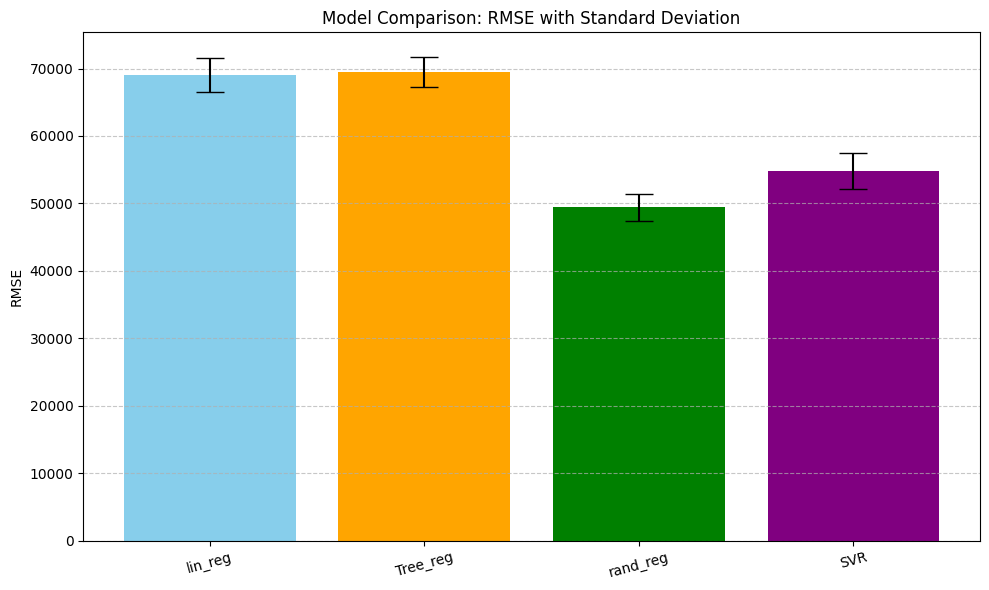

In [96]:
plt.figure(figsize=(10, 6))
bars = plt.bar(mean_rmse.index, mean_rmse.values, yerr=std_rmse.values, capsize=10, color=['skyblue', 'orange', 'green', 'purple'])
plt.ylabel("RMSE")
plt.title("Model Comparison: RMSE with Standard Deviation")
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.xticks(rotation=15)
plt.tight_layout()

In [102]:
print(mean_rmse)

lin_reg     69020.731896
Tree_reg    69496.998312
rand_reg    49416.459162
SVR         54836.045112
dtype: float64
